In [124]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib

In [104]:

def sample_homography(
        shape, perspective=True, scaling=True, rotation=True, translation=True,
        n_scales=5, n_angles=25, scaling_amplitude=0.2, perspective_amplitude_x=0.2,
        perspective_amplitude_y=0.2, patch_ratio=0.85, max_angle=1.57,
        allow_artifacts=False, translation_overflow=0.):
    """
    Computes the homography transformation from a random patch in the original image
    to a warped projection with the same image size.
    The original patch, which is initialized with a simple half-size centered crop, is
    iteratively projected, scaled, rotated and translated.

    Arguments:
        shape: A tuple specifying the height and width of the original image.
        perspective: A boolean that enables the perspective and affine transformations.
        scaling: A boolean that enables the random scaling of the patch.
        rotation: A boolean that enables the random rotation of the patch.
        translation: A boolean that enables the random translation of the patch.
        n_scales: The number of tentative scales that are sampled when scaling.
        n_angles: The number of tentatives angles that are sampled when rotating.
        scaling_amplitude: Controls the amount of scale.
        perspective_amplitude_x: Controls the perspective effect in x direction.
        perspective_amplitude_y: Controls the perspective effect in y direction.
        patch_ratio: Controls the size of the patches used to create the homography.
        max_angle: Maximum angle used in rotations.
        allow_artifacts: A boolean that enables artifacts when applying the homography.
        translation_overflow: Amount of border artifacts caused by translation.

    Returns:
        An np.array of shape `[3, 3]` corresponding to the flattened homography transform.
    """
    # Convert shape to ndarry
    if not isinstance(shape, np.ndarray):
        shape = np.array(shape)

    # Corners of the output patch
    margin = (1 - patch_ratio) / 2
    pts1 = margin + np.array([[0, 0], [0, patch_ratio],
                             [patch_ratio, patch_ratio], [patch_ratio, 0]])
    # Corners of the intput image
    pts2 = pts1.copy()

    # Random perspective and affine perturbations
    if perspective:
        if not allow_artifacts:
            perspective_amplitude_x = min(perspective_amplitude_x, margin)
            perspective_amplitude_y = min(perspective_amplitude_y, margin)

        # normal distribution with mean=0, std=perspective_amplitude_y/2
        perspective_displacement = np.random.normal(
            0., perspective_amplitude_y/2, [1])
        h_displacement_left = np.random.normal(0., perspective_amplitude_x/2,
                                               [1])
        h_displacement_right = np.random.normal(0., perspective_amplitude_x/2,
                                                [1])
        pts2 += np.stack([np.concatenate([h_displacement_left,
                                          perspective_displacement], 0),
                          np.concatenate([h_displacement_left,
                                          -perspective_displacement], 0),
                          np.concatenate([h_displacement_right,
                                          perspective_displacement], 0),
                          np.concatenate([h_displacement_right,
                                          -perspective_displacement], 0)])

    # Random scaling
    # sample several scales, check collision with borders, randomly pick a valid one
    if scaling:
        scales = np.concatenate([[1.], np.random.normal(1, scaling_amplitude/2, [n_scales])], 0)
        center = np.mean(pts2, axis=0, keepdims=True)
        scaled = (pts2 - center)[None, ...] * scales[..., None, None] + center
        # all scales are valid except scale=1
        if allow_artifacts:
            valid = np.arange(n_scales)
        else:
            valid = np.where(np.all((scaled >= 0.) & (scaled < 1.), (1, 2)))[0]
        idx = valid[np.random.uniform(0., valid.shape[0], ()).astype(np.int32)]
        pts2 = scaled[idx]

    # Random translation
    if translation:
        t_min, t_max = np.min(pts2, axis=0), np.min(1 - pts2, axis=0)
        if allow_artifacts:
            t_min += translation_overflow
            t_max += translation_overflow
        pts2 += (np.stack([np.random.uniform(-t_min[0], t_max[0], ()),
                           np.random.uniform(-t_min[1], t_max[1], ())]))[None, ...]

    # Random rotation
    # sample several rotations, check collision with borders, randomly pick a valid one
    if rotation:
        angles = np.linspace(-max_angle, max_angle, n_angles)
        # in case no rotation is valid
        angles = np.concatenate([[0.], angles], axis=0)
        center = np.mean(pts2, axis=0, keepdims=True)
        rot_mat = np.reshape(np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)], axis=1), [-1, 2, 2])
        rotated = np.matmul(
                np.tile((pts2 - center)[None, ...], [n_angles+1, 1, 1]),
                rot_mat) + center
        if allow_artifacts:
            valid = np.array(range(n_angles))  # all angles are valid, except angle=0
        else:
            valid = np.where(np.all((rotated >= 0.) & (rotated < 1.), axis=(1, 2)))[0]
        idx = valid[np.random.uniform(0., valid.shape[0], ()).astype(np.int32)]
        pts2 = rotated[idx]
        rot_angle = angles[idx]
    else: rot_angle = 0.

    # Rescale to actual size
    shape = shape[::-1].astype(np.float32)  # different convention [y, x]
    pts1 *= shape[None, ...]
    pts2 *= shape[None, ...]

    def ax(p, q): return [p[0], p[1], 1, 0, 0, 0, -p[0] * q[0], -p[1] * q[0]]

    def ay(p, q): return [0, 0, 0, p[0], p[1], 1, -p[0] * q[1], -p[1] * q[1]]

    a_mat = np.stack([f(pts1[i], pts2[i]) for i in range(4) for f in (ax, ay)], axis=0)
    p_mat = np.transpose(np.stack([[pts2[i][j] for i in range(4) for j in range(2)]], axis=0))
    homo_vec, _, _, _ = np.linalg.lstsq(a_mat, p_mat, rcond=None)

    # Compose the homography vector back to matrix
    homo_mat = np.concatenate([homo_vec[0:3, 0][None, ...],
                                homo_vec[3:6, 0][None, ...],
                                np.concatenate((homo_vec[6], homo_vec[7], [1]),
                                axis=0)[None, ...]], axis=0)

    return homo_mat, rot_angle



In [125]:
def plot_matches(kpts0, kpts1, color=None, lw=1.5, ps=4, indices=(0, 1)):
    """Plot matches for a pair of existing images.
    Args:
        kpts0, kpts1: corresponding keypoints of size (N, 2).
        color: color of each match, string or RGB tuple. Random if not given.
        lw: width of the lines.
        ps: size of the end points (no endpoint if ps=0)
        indices: indices of the images to draw the matches on.
    """
    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    ax0, ax1 = ax[indices[0]], ax[indices[1]]
    fig.canvas.draw()

    assert len(kpts0) == len(kpts1)
    if color is None:
        color = matplotlib.cm.hsv(np.random.rand(len(kpts0))).tolist()
    elif not isinstance(color[0], (tuple, list)):
        color = [color] * len(kpts0)

    # transform the points into the figure coordinate system
    transFigure = fig.transFigure.inverted()
    fkpts0 = transFigure.transform(ax0.transData.transform(kpts0))
    fkpts1 = transFigure.transform(ax1.transData.transform(kpts1))
    fig.lines += [matplotlib.lines.Line2D(
        (fkpts0[i, 0], fkpts1[i, 0]), (fkpts0[i, 1], fkpts1[i, 1]), zorder=1,
        transform=fig.transFigure, c=color[i], linewidth=lw)
        for i in range(len(kpts0))]

    # freeze the axes to prevent the transform to change
    ax0.autoscale(enable=False)
    ax1.autoscale(enable=False)

    if ps > 0:
        ax0.scatter(kpts0[:, 0], kpts0[:, 1], c=color, s=ps)
        ax1.scatter(kpts1[:, 0], kpts1[:, 1], c=color, s=ps)

In [127]:
plt.rcParams['figure.figsize'] = [16,16]
path = r'D:\dataset\SFM\ETH\Madrid_Metropolis\images\88713731_7eb342940c_o.jpg'
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]
ratio = 0.5
h_, w_ = int(h*ratio), int(w*ratio)
x1,y1 = int(w*(1-ratio)/2),int(h*(1-ratio)/2)
x2, y2 = x1+w_,y1+h_
patch = img[y1:y2,x1:x2]
img=cv2.rectangle(img,(x1,y1),(x2,y2),color=(0,255,0),thickness=3)

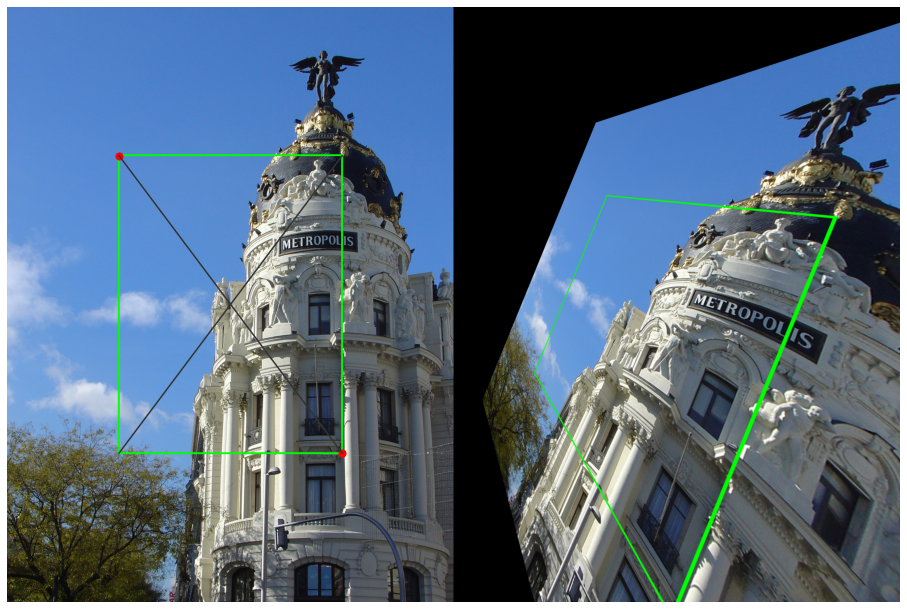

In [164]:
H,rot=sample_homography(img.shape[:2],patch_ratio=ratio,max_angle=1,allow_artifacts=True)
img_trans = cv2.warpPerspective(img,H,img.shape[:2][::-1])
img_show = np.concatenate((img,img_trans),axis=1)
plt.scatter([x1,x2],[y1,y2],s=50,c='r')
plt.plot([x1,x2],[y1,y2],color=[0.2,0.2,0.2])
plt.plot([x1,x2],[y2,y1],color=[0.2,0.2,0.2])
plt.imshow(img_show)
plt.axis('off')
plt.savefig('1.pdf')